# Starting comments
Charles Le Losq, Created 7 April 2015 for Python, Modified 23 Feb. 2016 for Julia

This IJulia notebook is aimed to show how you can easily fit a Raman spectrum with Julia , for free and, in my opinion, in an elegant way. Julia presents some advantages over Python (speed, in my opinion more simplicity as it is directly made for scientific computing) and inconvenients (young, so may have breakups, not that much libraries). But it is definitely worth the try. For optimisation I think the JuMP package does a really good job, leaving you lots of choice for your optimisation setup and algorithm.

The following fitting procedure phylosophie is totally in contradiction with most existing GUI softwares. It probably is a little bit harder to learn for the newcomer, but you have full control over the procedure.

In this example, we will fit the 850-1300 cm$^{-1}$ portion of a Raman spectrum of a lithium tetrasilicate glass Li$_2$Si$_4$O$_9$, the name will be abbreviated LS4 in the following. 

For further references for fitting Raman spectra of glasses, please see for instance: Virgo et al., 1980, Science 208, p 1371-1373; Mysen et al., 1982, American Mineralogist 67, p 686-695; McMillan, 1984, American Mineralogist 69, p 622-644; Mysen, 1990, American Mineralogist 75, p 120-134; Le Losq et al., 2014, Geochimica et Cosmochimica Acta 126, p 495-517 and Le Losq et al., 2015, Progress in Earth and Planetary Sciences 2:22.

We will use the optimization algorithms of Ipopt with JuMP. Please consult http://www.juliaopt.org/ for further details.

# Importing libraries
So the first part will be to import a bunch of libraries for doing various things (quite straightforward with Julia)

In [1]:
using JuMP
using PyPlot
using Ipopt
using SpectraJu

INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.4/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.4/Conda.ji for module Conda.
INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.4/LaTeXStrings.ji for module LaTeXStrings.


# Importing and looking at the data
Let's first have a look at the spectrum

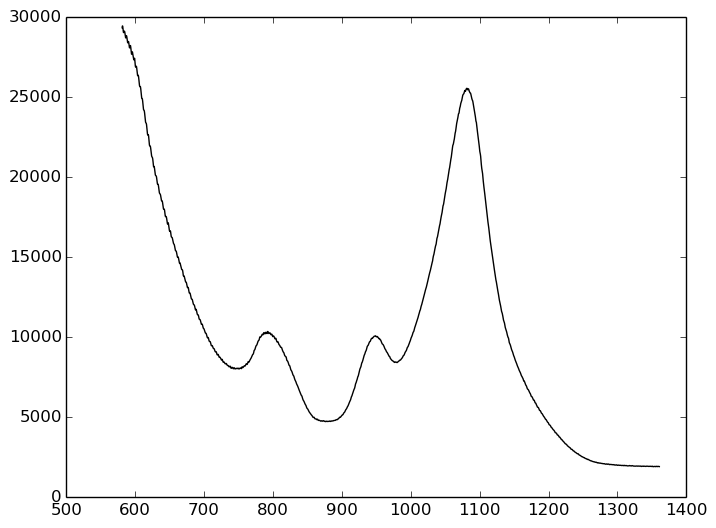

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1740bd1b10>

In [2]:
# get the spectrum to deconvolute, with skipping header and footer comment lines from the spectrometer
data = readdlm("./data/LS4.txt", '\t')
skip_header = 23
skip_footer = 121
inputsp = zeros(size(data)[1]-skip_header-skip_footer,2)
j = 1
for i = skip_header+1:size(data)[1]-skip_footer
    inputsp[j,1] = Float64(data[i,1])
    inputsp[j,2] = Float64(data[i,2])
    j = j + 1
end

# create a new plot for showing the spectrum
plot(inputsp[:,1],inputsp[:,2],color="black")

#xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
#ylabel("Normalized intensity, a. u.", fontsize = 14)
#title("Figure 1: the spectrum of interest",fontsize = 14, fontweight = "bold")

So we are looking at the 500-1300 cm$^{-1}$ portion of the Raman spectrum of the glass. We see a peak near 800 cm$^{-1}$, and two others near 950 and 1085 cm$^{-1}$. We will be interested in fitting the 870-1300 cm$^{-1}$ portion of this spectrum, which can be assigned to the various symmetric and assymetric stretching vibrations of Si-O bonds in the SiO$_2$ tetrahedra present in the glass network (see the above cited litterature for details).


# Baseline Removal

First thing we notice in Fig. 1, we have to remove a baseline because this spectrum is shifted from 0 by some "background" scattering. This quite typical in Raman spectra of glasses. Several ways exist to do so. We're going to the simplest stuff: a polynomial fitting the signal base around 870 and 1300 cm$^{-1}$. Other reasonnable solutions include a linear function, and a constant function. The two latter can be fitted between 1300 and 1350 cm$^{-1}$, but we will need to add another peak around 800 cm$^{-1}$. For now, the example is done with fitting the 870 cm$^{-1}$ portion of spectra, as this usually results in more robust final results.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver status: Optimal

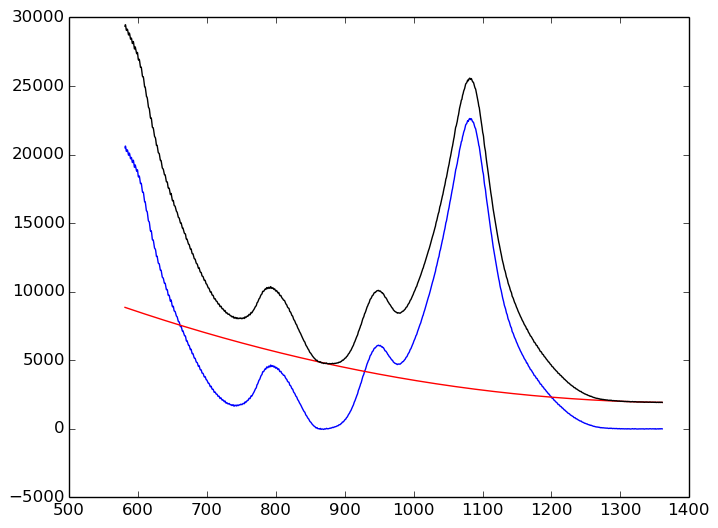

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f174002cc90>

In [3]:
roi = [[860.0 870.0]; [1300.0 1400.0]]
y_corr, y_bas = baseline(inputsp[:,1],inputsp[:,2],roi,"poly",[1.0,1.0,1.0])

#Creates a plot showing the baseline
plot(inputsp[:,1],y_corr[:,1],color="blue")
plot(inputsp[:,1],y_bas[:,1],color="red")
plot(inputsp[:,1],inputsp[:,2],color="black")

Now we will do some manipulation to have the interested portion of spectrum in a single variable. We will assume that the errors have not been drastically affected by the correction process (in some case it can be, but this one is quite straightforward), such that we will use the initial relative errors stored in the "ese0" variable.

In [4]:
index_interest = find(867.0 .< inputsp[:,1] .< 1300.0)

interestspectra = y_corr[index_interest,1]
ese0 = sqrt(abs(interestspectra[:,1]))/abs(interestspectra[:,1]) # the relative errors after baseline subtraction
interestspectra[:,1] = interestspectra[:,1]/trapz(inputsp[index_interest,1],interestspectra[:,1])*100 # normalise spectra to maximum intensity, easier to handle 

# First we simplify things by calling x, y and the frequency and intensity of spectra for later use
sigma = abs(ese0.*interestspectra[:,1]) #calculate good ese
x = inputsp[index_interest,1]
y = interestspectra[:,1]
println("Done")

Done


# Fitting the spectrum

All the fitting will be done using JuMP, and the Ipopt solver. Good thing, you can change the solver as you want. JuMP is just a way to express things (a little bit like lmfit under python, but much more flexible).

There was a long speach at this point in the Python version of this notebook, but Julia allows to fit very easily the spectrum. It is quite obvious in the following lines that we create a model, we define the variables containing the peaks amplitudes, frequency and widths (hwhm), and we set them. 

If more or less peaks are needed, simply change the number of peaks (variable m), and adjust the initial parameters after the setValue function calls.

Constraints are possible to implement too, quite easily. Usually Ipopt gives a very good results without needing constraints.

In [8]:
# The model for fitting baseline to roi signal
mod = Model(solver=IpoptSolver(print_level=0))
n = size(x)[1] # number of data
m = 5 #number of peaks, to be modified!

@defVar(mod,g_amplitudes[i=1:m] >= 0.0)
@defVar(mod,g_frequency[i=1:m])
@defVar(mod,20.0 <= g_hwhm[i=1:m] <= 40.0)

#Change the following parameters to adjust the model
setValue(g_amplitudes[i=1:m],[1,1,1,1,1])
setValue(g_frequency[i=1:m],[950,1050,1090,1140,1190])
setValue(g_hwhm[i=1:m],[30,30,30,30,30])

@defNLExpr(g_mod[j=1:n],sum{g_amplitudes[i] *exp(-log(2) * ((x[j]-g_frequency[i])/g_hwhm[i])^2), i = 1:m})

@setNLObjective(mod,Min,sum{(g_mod[j] - y[j])^2, j=1:n})
status = solve(mod)

:Optimal

We can now extract the parameters and the peaks, and plot the results. They speak for themself, no need to adopt a complicated process with first constraining peak frequency for instance, as it was necessary to do in Python.

In [ ]:
# parameter extractions
amplitudes = getValue(g_amplitudes)
frequency = getValue(g_frequency)
hwhm = getValue(g_hwhm)

model_peaks, peaks = gaussiennes(amplitudes,frequency,hwhm,x) # we construct the model representation and the individual peaks

#we plot the results
plot(x,y,color="blue")
plot(x,model_peaks,color="blue")
plot(x,peaks[:,:],color="red")


I discussed in the python version of this example that changing the algorithm can give you different results. This is quite true. The good thing is that JuMP just allows you to implement your model. You can change the solver and algorithm without any further difficulty when declaring the model:
    mod = Model(solver=IpoptSolver(print_level=0))
Very different solvers are available in Julia, and you can choose looking here: http://www.juliaopt.org/

Ipopt seems to be pretty good and should fit the needs of most problems quite well. But there is also NLopt, in which you can choose to use the Nelder-Mead algorithm for instance, or Mosek. 

# Error estimations

Errors can be estimated with using the covariance matrix if you use the Levenberg-Marquardt algorithm. 

If you use a large-scale gradient-less algorithm such as the Nelder-Mead or the Powell algorithms, you cannot do that. Thus, to calculate the errors on the parameters that those algorithms provide as well as the error introduced by choosing one or the other algorithm, we can use the bootstrapping technic. Several descriptions on the internet are available for this technic, so I will skip a complete description here.

A quick overview is to say that we have datapoints Yi affected by errors e_Yi. We assume that the probability density function of the Yi points is Gaussian. According to the Central Theorem Limit, this probably is a good assumption. Therefore, for each frequency in the spectrum of Fig.1, we have points that are probably at an intensity of Yi but with an error of e_Yi. To estimate how this uncertainties affect our fitting results, we can pick new points in the Gaussian distribution of mean Yi with a standard deviation e_Yi, and construct whole new spectra that we will fit. We will repeat this procedure N times.

In addition to that, we can also randomly choose between the Nelder-Mead or the Powell algorithm during the new fits, such that we will take also into account our arbitrary choice in the fitting algorithm for calculating the errors on the estimated parameters.

A last thing would be to randomly change a little bit the initial values of the parameters, but this is harder to implement so we will not do it for this example.

First of all, we have to write a Python function that will randomly sample the probability density functions of the points of the spectrum of Fig. 1. Here is the piece of code I wrote for doing so:

In [ ]:
#### Bootstrap function
def bootstrap(data, ese,nbsample):
    # Bootstrap of Raman spectra. We generate new datapoints with the basis of existing data and their standard deviation
    N = len(data)
    bootsamples = np.zeros((N,nbsample))
    for i in range(nbsample):
        for j in range(N):
            bootsamples[j,i] = np.random.normal(data[j], ese[j], size=None)
    return bootsamples

Now we will define how much new spectra we want to generate (the nbsample option of the bootstrap function), and we will run the previous function.

In [ ]:
nboot = 128 # Number of bootstrap samples
data_resampled = bootstrap(data,sigma,nboot)# resampling of data + generate the output parameter tensor

Now, we will create a loop which is going to look at each spectrum in the data_resampled variable, and to fit them with the procedure already described.

For doing so, we need to declare a couple of variables to record the bootstrap mean fitting error, in order to see if we generated enought samples to obtain a statistically representative bootstrapping process, and to record each set of parameters obtained for each bootstrapped spectrum.

In [ ]:
para_output = np.zeros((5,3,nboot)) # 5 x 3 parameters x N boot samples
bootrecord = np.zeros((nboot)) # For recording boot strap efficiency
        
for nn in range(nboot):
    algos = ['powell','nelder']
    algo = random.choice(algos) # We randomly select between the Powell or Nelder_mear algorithm
    params = Parameters()
    #               (Name,  Value,  Vary,   Min,  Max,  Expr) Here I directly initialize with fixed frequencies
    params.add_many(('a1',   24,   True,  0,      None,  None),
                ('f1',   946,   True, 910,    970,  None),
                ('l1',   26,   True,  20,      50,  None),
                ('a2',   35,   True,  0,      None,  None),
                ('f2',   1026,  True, 990,   1070,  None),
                ('l2',   39,   True,  20,   55,  None),  
                ('a3',   85,    True,    70,      None,  None),
                ('f3',   1082,  True, 1070,   1110,  None),
                ('l3',   31,   True,  25,   35,  None),  
                ('a4',   22,   True,  0,      None,  None),
                ('f4',   1140,  True, 1110,    1160,  None),
                ('l4',   35,   True,  20,   50,  None),  
                ('a5',   4,   True,  0,      None,  None),
                ('f5',   1211,  True, 1180,   1220,  None),
                ('l5',   28,   True,  20,   45,  None))

    result = minimize(residual, params, method = algo, args=(xfit, data_resampled[:,nn],sigma))
    # we release the positions but contrain the FWMH and amplitude of all peaks 
    params['f1'].vary = True
    params['f2'].vary = True
    params['f3'].vary = True
    params['f4'].vary = True
    params['f5'].vary = True

    result2 = minimize(residual, params,method = algo, args=(xfit, data_resampled[:,nn], sigma))
                           
    vv = params.valuesdict()
    para_output[0,0,nn] = vv['a1']
    para_output[1,0,nn] = vv['a2']
    para_output[2,0,nn] = vv['a3']
    para_output[3,0,nn] = vv['a4']
    para_output[4,0,nn] = vv['a5']
            
    para_output[0,1,nn] = vv['f1']
    para_output[1,1,nn] = vv['f2']
    para_output[2,1,nn] = vv['f3']
    para_output[3,1,nn] = vv['f4']
    para_output[4,1,nn] = vv['f5']
            
    para_output[0,2,nn] = vv['l1']
    para_output[1,2,nn] = vv['l2']
    para_output[2,2,nn] = vv['l3']
    para_output[3,2,nn] = vv['l4']
    para_output[4,2,nn] = vv['l5']
                
para_mean = np.mean(para_output,axis=2)
para_ese = np.std(para_output,axis=2)
for kjy in range(nboot):
    if kjy == 0:
        bootrecord[kjy] = 0
    else:
        bootrecord[kjy] = np.sum(np.std(para_output[:,:,0:kjy],axis=2))

We can have a view at the mean values and standard deviation of the parameters that have been generated by the bootstrapping:

In [ ]:
para_mean

In [ ]:
para_ese

Those errors are probably the best estimates of the errors that affect your fitting parameters. You can add another bootstrapping function for changing of, saying, 5 percents the initial estimations of the parameters, and you will have a complete and coherent estimation of the errors affecting the fits. But for most cases, the errors generated by this above bootstrapping technic are already quite robust.

We can see if we generated enought samples to have valid bootstrap results by looking at how the mean value of the parameters and their error converge. To do a short version of such thing, we can also look at how the summation of the errors of the parameters change with the iteration number. If the summation of errors becomes constant, we can say that we have generated enought bootstrap samples to have a significant result, statistically speaking.

In [ ]:
plt.plot(np.arange(nboot)+1,bootrecord,'ko')
plt.xlim(0,nboot+1)
plt.xlabel("Number of iterations",fontsize = 14)
plt.ylabel("Summed errors of parameters",fontsize = 14)
plt.title("Fig. 7: Bootstrap iterations for convergence",fontsize = 14, fontweight = 'bold')

We see from the above figure that the algorithm seems to have converged after 70 iterations. Therefore, we need to generate at least 70 spectra with the bootstrap function to obtain a good estimate of the errors that affect the parameters.

# Conclusion
This IPython notebook showed how spectra can be corrected from any baseline, how it is possible to use lmfit to fit it with Gaussian peaks, how changing the optimisation algorithm can change the results, and how we can estimate the errors on the calculated parameters with using the bootstrapping technic.

Several peak models are defined in the spectratools toolbox, or directly in lmfit. You can look at the relevant instructions for both software to use other peak models in the above calculation. Results can be saved in textfiles, through using the Python output functions like np.savetxt or other ways. See the relevant python documentation for doing so. Any comments on this program will be welcome.